In [1]:
import os
import utils
import model_scoring
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"  # or choose another backend if you wish
import pandas as pd
from bokeh.plotting import figure, output_file, show
from bokeh.models import ColumnDataSource, DatetimeTickFormatter
from bokeh.models.tools import HoverTool
from bokeh.io.export import get_screenshot_as_png
from bokeh.io import output_notebook
import sklearn
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import datetime
import keras
from keras.models import Sequential, Model
from keras.layers import Embedding, Flatten, Dense, Dropout, Input

Using plaidml.keras.backend backend.


In [2]:
output_notebook()

Loading BokehJS ...

In [3]:
train, test = utils.load_data()

Now, we will normalize the data.

In [4]:
mean = train.mean(axis=0)
std = train.std(axis=0)

utils.preprocess(train, mean, std)
utils.preprocess(test, mean, std)

In [5]:
labels = train['target'].tolist()
train.drop(columns=['target'], inplace=True)
train.head()

,PRCP,TMAX,TMIN,day_of_year_1,day_of_year_2,day_of_year_3,day_of_year_4,day_of_year_5,day_of_year_6,day_of_year_7,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
2005-03-03,-0.364319,-1.644261,-1.547583,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2016-01-17,-0.238134,-1.149823,-1.126503,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2015-06-06,0.115184,0.718051,0.678123,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2010-08-18,-0.364319,1.267426,1.399974,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2011-09-29,0.645160,0.553239,0.738277,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [6]:
main_input = Input(shape=(train.shape[1],), name='main_input')

x = Dense(128, activation='relu')(main_input)
x = Dropout(.25)(x)
x = Dense(64, activation='relu')(x)

output = Dense(1, name='output')(x)

model = Model(inputs=[main_input], outputs=output)
model.summary()

INFO:plaidml:Opening device "metal_amd_radeon_rx_580.0"


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 441)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               56576     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
output (Dense)               (None, 1)                 65        
Total params: 64,897
Trainable params: 64,897
Non-trainable params: 0
_________________________________________________________________


In [7]:
model.compile(optimizer='rmsprop',
              loss='mse',
              metrics=['mae'])
history = model.fit([train], labels,
                    epochs=20,
                    batch_size=32,
                    validation_split=0.2,
                   )

Train on 3969 samples, validate on 993 samples
Epoch 1/20
3969/3969 [==============================] - 1s 164us/step - loss: 0.2686 - mean_absolute_error: 0.3700 - val_loss: 0.1177 - val_mean_absolute_error: 0.2515
Epoch 2/20
3969/3969 [==============================] - 0s 125us/step - loss: 0.1171 - mean_absolute_error: 0.2481 - val_loss: 0.1150 - val_mean_absolute_error: 0.2421
Epoch 3/20
3969/3969 [==============================] - 1s 129us/step - loss: 0.1036 - mean_absolute_error: 0.2327 - val_loss: 0.0878 - val_mean_absolute_error: 0.2171
Epoch 4/20
3969/3969 [==============================] - 1s 132us/step - loss: 0.0907 - mean_absolute_error: 0.2175 - val_loss: 0.0822 - val_mean_absolute_error: 0.2112
Epoch 5/20
3969/3969 [==============================] - 1s 127us/step - loss: 0.0883 - mean_absolute_error: 0.2132 - val_loss: 0.0761 - val_mean_absolute_error: 0.2082
Epoch 6/20
3969/3969 [==============================] - 1s 158us/step - loss: 0.0798 - mean_absolute_error: 0.202

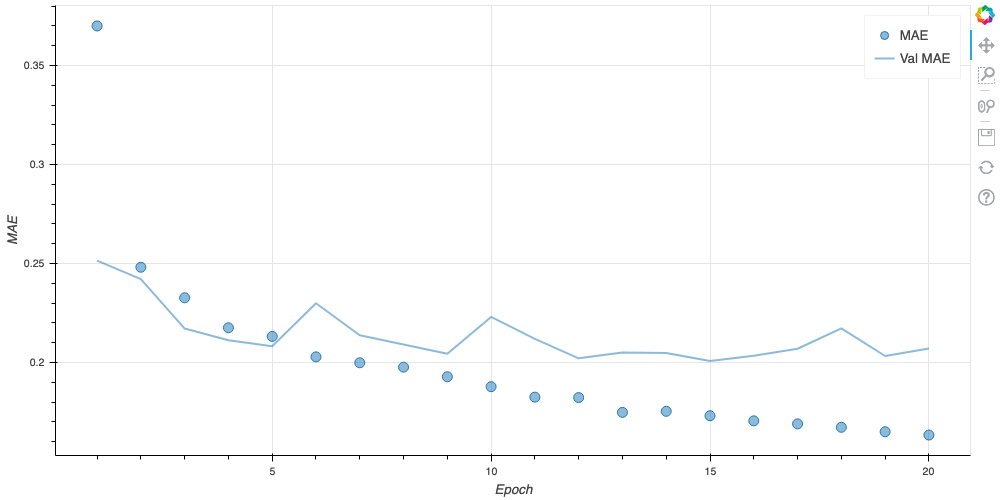

In [8]:
source = pd.DataFrame(history.history)
source['epoch'] = source.index + 1
acc_plot = figure(plot_width=1000, plot_height=500, x_axis_label='Epoch', y_axis_label='MAE')
acc_plot.circle(x='epoch', y='mean_absolute_error', source=source, size=10, fill_alpha=.5, legend_label='MAE')
acc_plot.line(x='epoch', y='val_mean_absolute_error', source=source, line_width=2, legend_label='Val MAE', alpha=0.5)
# show(acc_plot)
get_screenshot_as_png(acc_plot, driver=None)

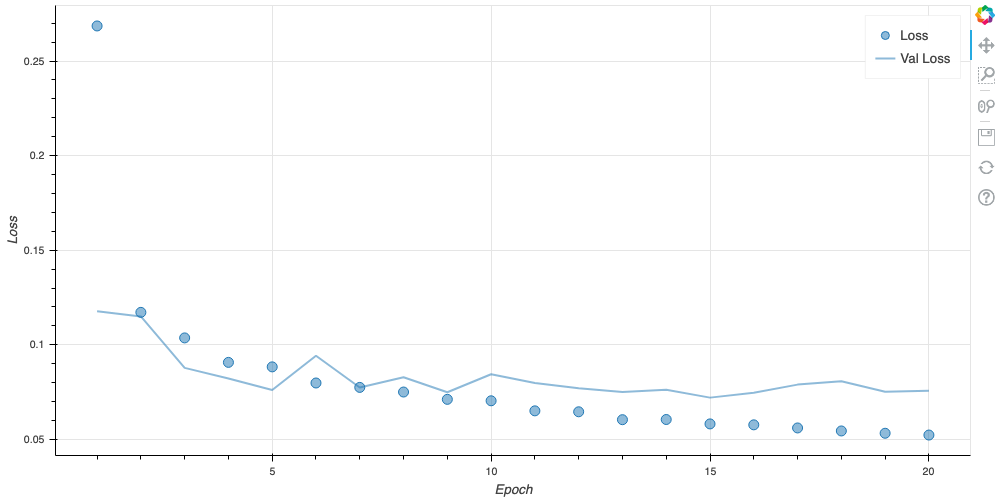

In [9]:
loss_plot = figure(plot_width=1000, plot_height=500, x_axis_label='Epoch', y_axis_label='Loss')
loss_plot.circle(x='epoch', y='loss', source=source, size=10, fill_alpha=.5, legend_label='Loss')
loss_plot.line(x='epoch', y='val_loss', source=source, line_width=2, legend_label='Val Loss', alpha=0.5)
# show(loss_plot)
get_screenshot_as_png(loss_plot, driver=None)

In [10]:
predictions = model.predict(test.copy().drop(columns=['target']))
isolf = utils.isolf()
results = test.join(isolf, how='inner')
results['prediction'] = predictions
results['target'] *= std.target
results['target'] += mean.target
results['prediction'] *= std.target
results['prediction'] += mean.target
results['date'] = results.index
results = results.astype({'prediction': 'float'})

results, pred_plot = model_scoring.eval(results)

Total prediction error: 113288.0
Total ISOLF prediction error: 63146.0
Percentage of time the model outperformed the NYISO model: 31.76 (175/551)


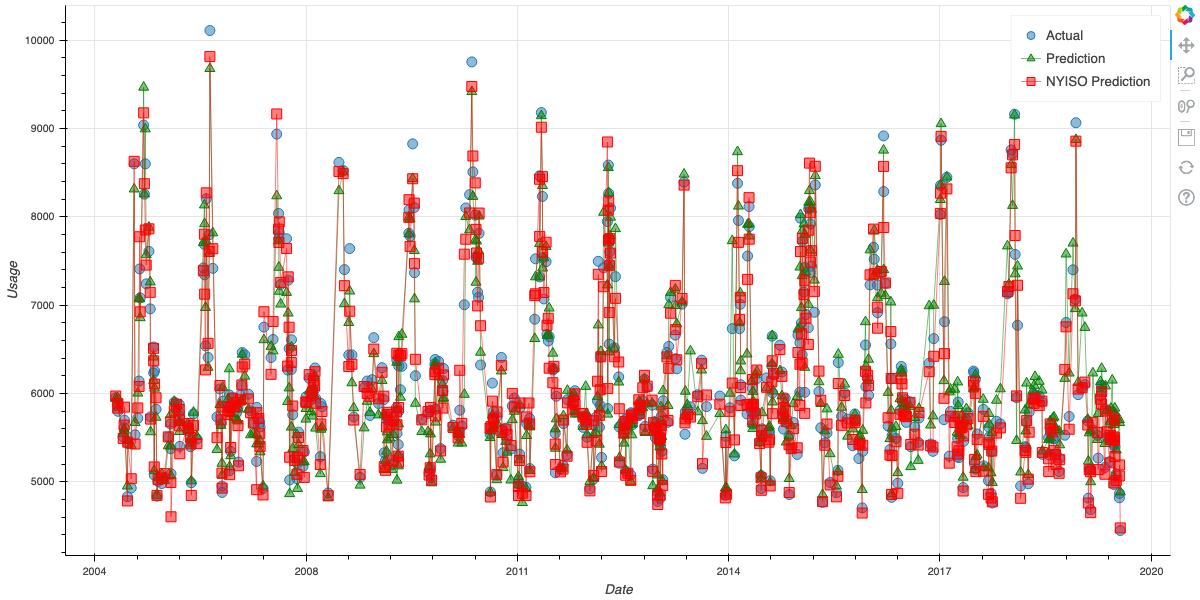

In [11]:
# show(pred_plot)
get_screenshot_as_png(pred_plot, driver=None)

In [12]:
results

,target,PRCP,TMAX,TMIN,day_of_year_1,day_of_year_2,day_of_year_3,day_of_year_4,day_of_year_5,day_of_year_6,...,month_8,month_9,month_10,month_11,month_12,nyiso_prediction,prediction,date,prediction_error,nyiso_prediction_error
2014-06-03,6732.903082,-0.061475,1.322364,0.978894,0,0,0,0,0,0,...,0,0,0,0,0,6116.583333,7728.216797,2014-06-03,-995.313715,616.319749
2005-07-10,6139.482474,-0.364319,1.487176,1.159357,0,0,0,0,0,0,...,0,0,0,0,0,6078.333333,7077.083008,2005-07-10,-937.600534,61.149141
2015-06-21,6438.205102,1.250847,1.377301,1.339819,0,0,0,0,0,0,...,0,0,0,0,0,6343.625000,7331.317871,2015-06-21,-893.112769,94.580102
2020-03-24,4818.006552,-0.364319,-0.435636,-0.765578,0,0,0,0,0,0,...,0,0,0,0,0,5064.791667,5702.976562,2020-03-24,-884.970011,-246.785115
2015-06-09,6570.978125,-0.339082,1.102614,1.159357,0,0,0,0,0,0,...,0,0,0,0,0,6330.000000,7429.060059,2015-06-09,-858.081934,240.978125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-07-19,7945.391034,-0.313845,0.718051,1.159357,0,0,0,0,0,0,...,0,0,0,0,0,8846.500000,7226.761230,2012-07-19,718.629804,-901.108966
2012-05-30,7495.878231,-0.339082,0.718051,1.159357,0,0,0,0,0,0,...,0,0,0,0,0,7348.625000,6773.780273,2012-05-30,722.097958,147.253231
2011-07-13,8463.319192,-0.086712,1.267426,1.219511,0,0,0,0,0,0,...,0,0,0,0,0,8424.083333,7695.348633,2011-07-13,767.970559,39.235859
2016-09-10,8284.815700,-0.364319,1.487176,1.520282,0,0,0,0,0,0,...,0,1,0,0,0,7877.708333,7399.686523,2016-09-10,885.129176,407.107366
